## TRANSFER LEARNING WITH TENSORFLOW PART 1 : FEATURE EXTRACTION

In [ ]:
!nvidia-smi

Fri Jul 22 04:45:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##DOWNLOADING AND BECOMING ONE WITH THE DATA

In [ ]:
# Getting Data
import zipfile

# Downloading The Data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzipping The Downloaded File
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-07-22 04:51:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.212.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   293MB/s    in 0.5s    

2022-07-22 04:51:46 (293 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"THERE ARE {len(dirnames)} DIRECTORIES AND {len(filenames)} IMAGES IN '{dirpath}'.")

THERE ARE 2 DIRECTORIES AND 0 IMAGES IN '10_food_classes_10_percent'.
THERE ARE 10 DIRECTORIES AND 0 IMAGES IN '10_food_classes_10_percent/train'.
THERE ARE 0 DIRECTORIES AND 75 IMAGES IN '10_food_classes_10_percent/train/hamburger'.
THERE ARE 0 DIRECTORIES AND 75 IMAGES IN '10_food_classes_10_percent/train/ice_cream'.
THERE ARE 0 DIRECTORIES AND 75 IMAGES IN '10_food_classes_10_percent/train/fried_rice'.
THERE ARE 0 DIRECTORIES AND 75 IMAGES IN '10_food_classes_10_percent/train/grilled_salmon'.
THERE ARE 0 DIRECTORIES AND 75 IMAGES IN '10_food_classes_10_percent/train/ramen'.
THERE ARE 0 DIRECTORIES AND 75 IMAGES IN '10_food_classes_10_percent/train/chicken_curry'.
THERE ARE 0 DIRECTORIES AND 75 IMAGES IN '10_food_classes_10_percent/train/pizza'.
THERE ARE 0 DIRECTORIES AND 75 IMAGES IN '10_food_classes_10_percent/train/steak'.
THERE ARE 0 DIRECTORIES AND 75 IMAGES IN '10_food_classes_10_percent/train/chicken_wings'.
THERE ARE 0 DIRECTORIES AND 75 IMAGES IN '10_food_classes_10_percent

##CREATING DATA LOADERS (PREPARING THE DATA)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32


train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/225.)
test_datagen = ImageDataGenerator(rescale=1/225.)

print('TRAINING IMAGES:')
train_data_10percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical')

print('TEST IMAGES')
test_data_10percent = test_datagen.flow_from_directory(test_dir,
                                                       target_size=IMAGE_SHAPE,
                                                       batch_size=BATCH_SIZE,
                                                       class_mode='categorical')


TRAINING IMAGES:
Found 750 images belonging to 10 classes.
TEST IMAGES
Found 2500 images belonging to 10 classes.


##SETTING UP CALLBACKS (THINGS TO RUN WHILST OUR MODEL TRAINS)

In [ ]:
# Creating TensorBoard Callback Function(Functionized Because We Need To Create A New One For Each Model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'SAVING TENSORBOARD LOG FILES TO: {log_dir}')
  return tensorboard_callback

##CREATING MODELS USING TENSORFLOW HUB

In [ ]:
# Let's Compare The Following Two Models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Making A create_model() function To Create A Model From A URL
def create_model(model_url, num_classes=10):
  """
  Takes A TensorFlow Hub URL And Creates A Keras Sequential Model With It

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL
    num_classes (int): Number Of Output Neurons In The Output Layer

  Returns:
    An Uncompiled Keras Sequential Model With model_url As Feature Extractor Layer
    And Dense Output layer With num_classes Output Neurons.
  """
  # Downloading The PreTrained Model And Saving It As A Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Creating our Sequential Model
  model = tf.keras.Sequential([
       feature_extractor_layer,
       layers.Dense(num_classes, activation='softmax', name='output_layer')                       
  ])

  return model

##CREATING AND TESTING ResNet TENSORFLOW HUB FEATURE EXTRACTION MODEL

In [ ]:
# Creating Resnet Model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10percent.num_classes)

In [ ]:
# Compiling Our Resnet Model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])
# Fitting The Model
resnet_history = resnet_model.fit(train_data_10percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10percent),
                               validation_data=test_data_10percent,
                               validation_steps=len(test_data_10percent),
                               callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                      experiment_name='resnet50V2'
                                                                      )])

SAVING TENSORBOARD LOG FILES TO: tensorflow_hub/resnet50V2/20220722-062700
Epoch 1/5
24/24 [==============================] - 32s 743ms/step - loss: 1.8096 - accuracy: 0.3987 - val_loss: 1.1815 - val_accuracy: 0.6152
Epoch 2/5
24/24 [==============================] - 16s 670ms/step - loss: 0.8600 - accuracy: 0.7427 - val_loss: 0.8668 - val_accuracy: 0.7244
Epoch 3/5
24/24 [==============================] - 16s 699ms/step - loss: 0.5888 - accuracy: 0.8320 - val_loss: 0.7539 - val_accuracy: 0.7520
Epoch 4/5
24/24 [==============================] - 16s 667ms/step - loss: 0.4591 - accuracy: 0.8733 - val_loss: 0.7004 - val_accuracy: 0.7728
Epoch 5/5
24/24 [==============================] - 16s 665ms/step - loss: 0.3637 - accuracy: 0.9147 - val_loss: 0.6824 - val_accuracy: 0.7692


##CREATING A FUNCTION TO PLOT LOSS CURVES

In [ ]:
import matplotlib.pyplot as plt

# Plotting The Validation And Training Curves
def plot_loss_curves(history):
  """
  RETURNS SEPARATE LOSS CURVES FOR TRAINING AND VALIDATION METRICS.

  Args:
    history: TensorFlow History Object.

  Returns:
    Plots Of Training/Validation Loss And Accuracy Metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plotting Loss
  plt.plot(epochs, loss, label='TRAINING_LOSS')
  plt.plot(epochs, val_loss, label='VAL_LOSS')
  plt.title('LOSS')
  plt.legend()

  # Plotting Accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='TRAINING_ACCURACY')
  plt.plot(epochs, val_accuracy, label='VAL_ACCURACY')
  plt.title('ACCURACY')
  plt.xlabel('EPOCHS')
  plt.legend();

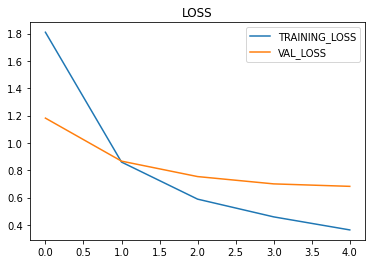

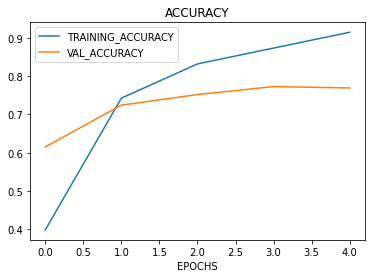

In [ ]:
plot_loss_curves(resnet_history)

##CREATING AND TESTING EfficientNet80 TENSORFLOW HUB FEATURE EXTRACTION MODEL

In [ ]:
# Creating EfficientNetB0 Feature Extractor Model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10percent.num_classes)

# Compiling The Model
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])
# Fitting The Model
efficientnet_history = efficientnet_model.fit(train_data_10percent,
                                          epochs=5,
                                          steps_per_epoch=len(train_data_10percent),
                                          validation_data=test_data_10percent,
                                          validation_steps=len(test_data_10percent),
                                          callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                 experiment_name='efficientnetB0')])

SAVING TENSORBOARD LOG FILES TO: tensorflow_hub/efficientnetB0/20220722-070454
Epoch 1/5
24/24 [==============================] - 26s 710ms/step - loss: 1.8246 - accuracy: 0.4360 - val_loss: 1.3222 - val_accuracy: 0.7100
Epoch 2/5
24/24 [==============================] - 16s 678ms/step - loss: 1.0864 - accuracy: 0.7587 - val_loss: 0.9057 - val_accuracy: 0.8016
Epoch 3/5
24/24 [==============================] - 15s 645ms/step - loss: 0.7848 - accuracy: 0.8267 - val_loss: 0.7341 - val_accuracy: 0.8312
Epoch 4/5
24/24 [==============================] - 15s 641ms/step - loss: 0.6308 - accuracy: 0.8600 - val_loss: 0.6419 - val_accuracy: 0.8480
Epoch 5/5
24/24 [==============================] - 15s 638ms/step - loss: 0.5340 - accuracy: 0.8813 - val_loss: 0.5878 - val_accuracy: 0.8532


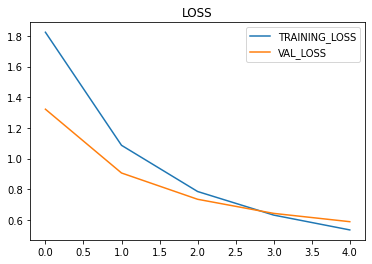

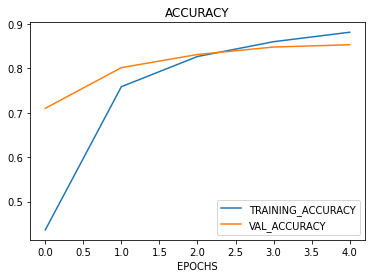

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


##COMPARING OUR MODELS USING TENSORBOARD

In [ ]:
# Uploading TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientnetB0 Vs. ResNet50V2" \
  --description 'COMPARING TWO DIFFERENT TFHub FEATURE EXTRACTION MODEL ARCHITECTURES USING 10% OF THE TRAINING DATA' \
  --one_shot

My TensorBoard Link : https://tensorboard.dev/experiment/6Qs88iV1SaGpJbHX23Ngpw/

In [ ]:
# Checking What TensorBoard Experiments We Have
!tensorboard dev list

https://tensorboard.dev/experiment/6Qs88iV1SaGpJbHX23Ngpw/
	Name                 EfficientnetB0 Vs. ResNet50V2
	Description          COMPARING TWO DIFFERENT TFHub FEATURE EXTRACTION MODEL ARCHITECTURES USING 10% OF THE TRAINING DATA
	Id                   6Qs88iV1SaGpJbHX23Ngpw
	Created              2022-07-22 07:31:01 (7 minutes ago)
	Updated              2022-07-22 07:31:03 (7 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5924914
Total: 1 experiment(s)
